# MobileNetV2 모델 만들기
### 문제점
기존 CNN 모델의 경우 모델의 크기와 정확도 면에서 목표에 미달함.  
새로 도입한 MobileNetV2의 경우
+ parameter 수를 75% 감소시켰으며 총 연산량은 더 큰 감소를 보인 것으로 추측됨
+ 99.44%의 초-중-종성 joint accuracy를 보였으며 이는 기존 연구 결과보다 우수함
#### 모델의 크기
사용한 CNN 모델의 경우 총 6번의 convolution layer에서 600만여 개의 parameter를 사용함.
이때 각각의 convolution layer에서 parameter 수는 다음과 같음.  
$$(parameter\ 수) = (K_h​ \times K_w​ \times C_{in} ​+ bias 사용 여부) \times C_{out}​$$
*($K_h, K_w$ = 커널 크기, $C_{in}$ = 입력 채널 수, $C_{out}$ = 출력 채널 수)*  
이때 연산 횟수는 대략 $H_{out} \times W_{out} \times C_{out} \times (K_h \times K_w \times C_{in})$ (지수는 차례대로 출력 feature map의 높이/너비, 입력 채널 수, 커널 높이/너비, 출력 채널 수) 회.  
예를 들어, 사용한 모델의 Conv2D_5에서는 $(3\times3\times512+1)\times512=2\ 359\ 296$개의 parameter가 있으며, 이 layer에서의 연산 횟수는 약 $4 \times 4 \times 512 \times 3 \times 3 \times 512 = 37\ 748\ 736$회가 됨.  
NVIDIA RTX 5060 Ti를 기준으로, 이 모델의 훈련 속도는 BATCH_SIZE=32에서 약 60ms로, 1epoch 학습 시 30분 정도가 소요됨. 따라서 더 빠른 모델이 필요하다고 판단함.
#### 모델의 정확도
초기 AI Hub에서 학습 시에 필기체와 인쇄체가 혼합된 약 34만 개의 데이터 세트를 사용함. 이때, 데이터셋의 범위는 일상에서 자주 사용되는 KSX1001 글자 세트만을 사용.  
이때 KSX1001은 오래된 프로토콜이기 때문에 현대 모바일 환경에서 필요한 몇몇 글자들이 빠져 있으며, 본 연구에서는 KSX1001에 포함되지 않는 모든 한글 인식을 목표로 하였다.  
학습 결과, 기존의 CNN 모델은 98%대의 정확도를 보였으며, KSX1001 이외의 필기체를 인식하는 데 어려움을 겪음.  
따라서 데이터셋을 바꾸는 방향(장근산)과 기존 데이터셋에서 새로운 모델을 가져오는 방향(이지용)으로 나누어 각자 추가 연구를 진행하였으며, 최종적으로 본 모델인 MobileNetV2를 선정.
### 선행 연구 자료
CNN을 기반으로 한 모델 중 CRNN, Resnet, GoogLeNet, MobileNetV2 등을 살펴봄.  
논문(Handwritten Hangul Recognition Model Using Multi‑Label Classification(H. Choi, 2023))에서, MobileNetV2를 이용해  
### MobileNetV2 소개
MobileNetV2는 Google에서 2018년 발표한 인공지능 모델로, 적은 파라미터 수로 모바일/IoT 등 저사양 기기에서도 원활하게 구동되는 빠른 인공지능을 목표로 함.


## 데이터 전처리
vectorization_local.py에서
- 이미지를 전처리해 128 * 128 * 3의 텐서로 만든 후
- 향상된 학습 속도를 위해서 흑백 처리
- 이후 THRESHOLD 기분으로 명도를 나누어서 128 * 128 * 1의 bool로 바꾸고
- 평균 명도 기준 상하위 5%의 이미지와 라벨은 학습 자료에서 제외함.
    + 일단 제외하지 않고 학습 실시함.

이 코드는 인공지능으로 자동 생성한 코드로, 생성된 데이터를 낱개로 불러와 이미지로 변환하여 수동으로 최적의 THRESHOLD 값을 확인해볼 수 있음.

📎 Input: /home/voxfish_ljy$/virtual/1.글자/013/01330001026.jpg
✅ Resized & padded (white background)


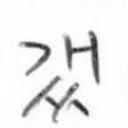

✅ Blurred


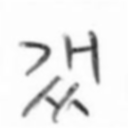

✅ Binary threshold result


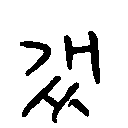

📎 Input: /home/voxfish_ljy$/virtual/1.글자/013/01330001026.jpg
✅ Resized & padded (white background)


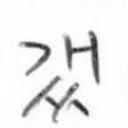

✅ Blurred


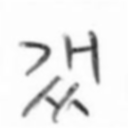

✅ Binary threshold result


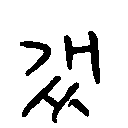

In [4]:
import tensorflow as tf
from IPython.display import display
from PIL import Image
import numpy as np

IMG_SIZE = 128
THRESHOLD = 0.8

def preprocess_for_view(path, threshold = THRESHOLD):
    bytes_ = tf.io.read_file(path)
    img = tf.image.decode_jpeg(bytes_, channels=1)  # original size (H, W, 1)

    # normalize [0,1]
    img = tf.cast(img, tf.float32) / 255.0

    # ----------- padded resize with white background (1.0) -----------
    h, w, _ = img.shape
    scale = tf.minimum(IMG_SIZE / h, IMG_SIZE / w)
    nh = tf.cast(tf.round(h * scale), tf.int32)
    nw = tf.cast(tf.round(w * scale), tf.int32)

    img = tf.image.resize(img, (nh, nw))

    pad_top    = (IMG_SIZE - nh) // 2
    pad_bottom = IMG_SIZE - nh - pad_top
    pad_left   = (IMG_SIZE - nw) // 2
    pad_right  = IMG_SIZE - nw - pad_left

    # pad with 1.0 → white background
    img = tf.pad(img, [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], constant_values=1.0)

    # ----------- blur & threshold -----------
    img_blur = tf.nn.avg_pool2d(img[None, ...], ksize=3, strides=1, padding='SAME')[0]
    bin_img = tf.where(img_blur > THRESHOLD, 1.0, 0.0)

    return img, img_blur, bin_img

def show_preprocess_steps(path, threshold):
    raw, blur, binary = preprocess_for_view(path, threshold)

    def show_tensor(t):
        img = (t.numpy().squeeze() * 255).astype(np.uint8)
        display(Image.fromarray(img))

    print("📎 Input:", path)
    print("✅ Resized & padded (white background)")
    show_tensor(raw)

    print("✅ Blurred")
    show_tensor(blur)

    print("✅ Binary threshold result")
    show_tensor(binary)

show_preprocess_steps(r"/home/voxfish_ljy$/virtual/1.글자/013/01330001026.jpg", 0.8)
show_preprocess_steps(r"/home/voxfish_ljy$/virtual/1.글자/013/01330001026.jpg", 0.75)

## 모델 몸체
증강, 모델 몸체, 콜백~실행 부분은 직접 구상. 기타 코드는 팀원 코드 재활용.
ChatGPT 사용하여 주석 및 리팩토링함.

In [ ]:
import os, glob, random, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models

# ======= 하이퍼파라미터 =======
IMG_SIZE     = 128
NUM_CLASSES  = 68                 # [초성19 | 중성21 | 종성28]
BATCH_SIZE   = 128
EPOCHS       = 300
INIT_LR      = 1e-3
TRAIN_RATIO  = 0.75
ALPHA        = 0.75               # MobileNetV2 width multiplier
AUG_ON       = True               # 증강 on/off
MODE         = "stem"             # "stem" (권장) | "native"
OUT_DIR      = "./runs_MobileNetV2"
SHARD_DIR    = r"/home/voxfish_ljy$/virtual/Data"

AUTOTUNE     = tf.data.AUTOTUNE

# ======= L/V/T 슬라이스 인덱스 =======
L_SLICE = slice(0, 19)
V_SLICE = slice(19, 40)
T_SLICE = slice(40, 68)

# ---------------------------------------------------------
# 증강
# ---------------------------------------------------------
def hangul_ocr_augment():
    return tf.keras.Sequential([
        layers.RandomRotation(0.1),
        layers.RandomTranslation(0.15, 0.15),
        layers.RandomZoom(0.20),
        layers.RandomHeight(0.10),
        layers.RandomWidth(0.10),
    ], name="hangul_aug")

# ---------------------------------------------------------
# 모델
# ---------------------------------------------------------
def build_mobilenetv2(mode="stem", alpha=0.75, dropout=0.25, aug=True):
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="image")
    x = layers.Rescaling(2.0, offset=-1.0, name="to_minus1_1")(inp)
    if aug:
        x = hangul_ocr_augment()(x)

    # 1채널 -> 3채널 투영(호환성↑)
    x3 = layers.Conv2D(3, 1, padding="same", use_bias=False, name="stem_1x1")(x)
    base = tf.keras.applications.MobileNetV2(
        input_tensor=x3, include_top=False, weights=None, alpha=alpha, pooling="avg",
    )
    h = base.output

    h = layers.Dropout(dropout, name="head_dropout")(h)
    out = layers.Dense(NUM_CLASSES, activation=None, name="char68", dtype="float32")(h)
    return models.Model(inp, out, name=f"mobilenetv2_{mode}")

# ---------------------------------------------------------
# 커스텀 메트릭(학습 로그에 바로 표기)
# ---------------------------------------------------------
def acc_first(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, L_SLICE], -1), tf.argmax(y_pred[:, L_SLICE], -1)),
            tf.float32
        )
    )

def acc_middle(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, V_SLICE], -1), tf.argmax(y_pred[:, V_SLICE], -1)),
            tf.float32
        )
    )

def acc_last(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, T_SLICE], -1), tf.argmax(y_pred[:, T_SLICE], -1)),
            tf.float32
        )
    )

def acc_joint(y_true, y_pred):
    l_ok = tf.equal(tf.argmax(y_true[:, L_SLICE], -1), tf.argmax(y_pred[:, L_SLICE], -1))
    v_ok = tf.equal(tf.argmax(y_true[:, V_SLICE], -1), tf.argmax(y_pred[:, V_SLICE], -1))
    t_ok = tf.equal(tf.argmax(y_true[:, T_SLICE], -1), tf.argmax(y_pred[:, T_SLICE], -1))
    return tf.reduce_mean(tf.cast(l_ok & v_ok & t_ok, tf.float32))

# ---------------------------------------------------------
# 샤드 → tf.data
# ---------------------------------------------------------
def _per_shard_dataset(x_path, y_path, shuffle_inside=True):
    # 메모리는 memmap 유지 (RAM 폭증 방지)
    X = np.load(x_path, mmap_mode="r")   # (N,150,150,1) uint8
    Y = np.load(y_path, mmap_mode="r")   # (N,68) float32
    n = X.shape[0]

    # 인덱스 스트림을 만들고, 인덱스로 memmap에 접근
    ds = tf.data.Dataset.from_tensor_slices(tf.range(n, dtype=tf.int64))
    if shuffle_inside:
        ds = ds.shuffle(8192)

    def _load_one_py(i):
        i = int(i)
        return X[i], Y[i]   # numpy 배열 반환 (uint8, float32)

    def _load_one(i):
        xi, yi = tf.py_function(
            _load_one_py, [i], [tf.uint8, tf.float32]
        )
        # 정적 shape 명시 (그래프 추론 도움)
        xi.set_shape((IMG_SIZE, IMG_SIZE, 1))
        yi.set_shape((NUM_CLASSES,))
        # 전처리
        x = tf.cast(xi, tf.float32)
        x = tf.cond(tf.reduce_max(x) > 1.5, lambda: x / 255.0, lambda: x)
        y = yi
        return x, y

    ds = ds.map(_load_one, num_parallel_calls=AUTOTUNE)
    return ds

def build_ds_from_numpy_shards(
    shard_dir: str,
    batch_size: int = 256,
    train_ratio: float = 0.9,
    interleave_across_shards: bool = True,
    repeat: bool = False,
    shuffle_files: bool = True,
):
    X_files = sorted(glob.glob(os.path.join(shard_dir, "X_shard_*.npy")))
    Y_files = sorted(glob.glob(os.path.join(shard_dir, "Y_shard_*.npy")))
    assert len(X_files) == len(Y_files) and len(X_files) > 0, "샤드 파일이 없거나 개수가 불일치합니다."

    idxs = list(range(len(X_files)))
    if shuffle_files:
        random.shuffle(idxs)

    split = int(len(idxs) * train_ratio)
    train_idx, val_idx = idxs[:split], idxs[split:]

    def make_combo(idxs, shuffle_inside=True):
        shards = [_per_shard_dataset(X_files[i], Y_files[i], shuffle_inside=shuffle_inside) for i in idxs]
        if interleave_across_shards and len(shards) > 1:
            ds = tf.data.Dataset.sample_from_datasets(shards)
        else:
            ds = shards[0]
            for s in shards[1:]:
                ds = ds.concatenate(s)
        if repeat:
            ds = ds.repeat()
        ds = ds.batch(batch_size).prefetch(AUTOTUNE)
        return ds

    train_ds = make_combo(train_idx, shuffle_inside=True)
    val_ds   = make_combo(val_idx, shuffle_inside=True) if val_idx else None
    return train_ds, val_ds, len(train_idx), len(val_idx)

# ---------------------------------------------------------
# 오프라인 평가 (원하는 시점에 호출)
# ---------------------------------------------------------
def eval_lvt_metrics(model, dataset, max_batches=None):
    L_right = V_right = T_right = Joint_right = 0
    total = 0
    for b, (X, Y) in enumerate(dataset):
        P = model.predict(X, verbose=0)  # (B,68)

        yL = np.argmax(Y[:, L_SLICE], axis=1)
        yV = np.argmax(Y[:, V_SLICE], axis=1)
        yT = np.argmax(Y[:, T_SLICE], axis=1)

        pL = np.argmax(P[:, L_SLICE], axis=1)
        pV = np.argmax(P[:, V_SLICE], axis=1)
        pT = np.argmax(P[:, T_SLICE], axis=1)

        L_right += np.sum(yL == pL)
        V_right += np.sum(yV == pV)
        T_right += np.sum(yT == pT)
        Joint_right += np.sum((yL == pL) & (yV == pV) & (yT == pT))
        total += X.shape[0]

        if max_batches is not None and (b + 1) >= max_batches:
            break

    return {
        "acc_first": L_right / total,
        "acc_mid": V_right / total,
        "acc_last": T_right / total,
        "acc_joint": Joint_right / total,
        "samples": total,
    }

# ---------------------------------------------------------
# 학습 루틴
# ---------------------------------------------------------
def compile_and_train():
    os.makedirs(OUT_DIR, exist_ok=True)

    # 1) 데이터
    train_ds, val_ds, n_tr, n_va = build_ds_from_numpy_shards(
        shard_dir=SHARD_DIR,
        batch_size=BATCH_SIZE,
        train_ratio=TRAIN_RATIO,
        interleave_across_shards=True,
        repeat=False,
        shuffle_files=True,
    )
    print(f"train shards: {n_tr}, val shards: {n_va}")

    def hangul_loss(y_true, logits):
        cho = tf.nn.softmax_cross_entropy_with_logits(
            labels=y_true[:, L_SLICE],
            logits = logits[:, L_SLICE]
        )
        jung = tf.nn.softmax_cross_entropy_with_logits(
            labels=y_true[:, V_SLICE],
            logits = logits[:, V_SLICE]
        )
        jong = tf.nn.softmax_cross_entropy_with_logits(
            labels=y_true[:, T_SLICE],
            logits = logits[:, T_SLICE]
        )
        return cho+jung+jong
    # 2) 모델
    model = build_mobilenetv2(mode=MODE, alpha=ALPHA, dropout=0.25, aug=AUG_ON)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(INIT_LR),
        loss=hangul_loss,
        metrics=[acc_first, acc_middle, acc_last, acc_joint],
    )
    model.summary()

    # 3) 콜백
    ckpt_path = os.path.join(OUT_DIR, "ckpt_best.keras")
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            ckpt_path, monitor="val_acc_joint",
            save_best_only=True, save_weights_only=False, mode="max"
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=3e-6, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
        ),
        tf.keras.callbacks.CSVLogger(os.path.join(OUT_DIR, "train.csv")),
        tf.keras.callbacks.TensorBoard(log_dir=os.path.join(OUT_DIR, "tb")),
    ]

    # 4) 학습
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )

    # 5) 최종 저장
    model.save(os.path.join(OUT_DIR, "final.keras"))

    # 6) 검증 세트에서 L/V/T/Joint 지표 출력
    if val_ds is not None:
        metrics = eval_lvt_metrics(model, val_ds)
        print("\n========== L/V/T/Joint metrics on VAL ==========")
        print(f"Samples   : {metrics['samples']}")
        print(f"초성 정확도 : {metrics['acc_first']}")
        print(f"중성 정확도 : {metrics['acc_mid']}")
        print(f"종성 정확도 : {metrics['acc_last']}")
        print(f"총 정확도   : {metrics['acc_joint']}")
        print("===============================================\n")

    return model, history, (train_ds, val_ds)

# ---------------------------------------------------------
# 실행
# ---------------------------------------------------------
if __name__ == "__main__":
    # (선택) 혼합정밀도: 지원 GPU면 주석 해제
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
    compile_and_train()

train shards: 6, val shards: 2


Model: "mobilenetv2_stem"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ to_minus1_1         │ (None, 128, 128,  │          0 │ image[0][0]       │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hangul_aug          │ (None, None,      │          0 │ to_minus1_1[0][0] │
│ (Sequential)        │ None, 1)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_1x1 (Conv2D)   │ (None, None,      │          3 │ hangul_aug[0][0]  │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        648 │ stem_1x1[0][0]    │
│                     │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │         96 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        216 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │         96 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        384 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0

 Total params: 1,469,175 (5.60 MB)

 Trainable params: 1,442,535 (5.50 MB)

 Non-trainable params: 26,640 (104.06 KB)

Epoch 1/300
   1234/Unknown 426s 334ms/step - acc_first: 0.3598 - acc_joint: 0.1711 - acc_last: 0.4627 - acc_middle: 0.3964 - loss: 5.5364

2025-11-25 06:35:55.016185: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1234/1234 ━━━━━━━━━━━━━━━━━━━━ 523s 412ms/step - acc_first: 0.6182 - acc_joint: 0.4044 - acc_last: 0.6969 - acc_middle: 0.6351 - loss: 3.1956 - val_acc_first: 0.0579 - val_acc_joint: 2.1609e-04 - val_acc_last: 0.1429 - val_acc_middle: 0.0771 - val_loss: 8.9699 - learning_rate: 0.0010
Epoch 2/300
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 503s 407ms/step - acc_first: 0.9161 - acc_joint: 0.7950 - acc_last: 0.9341 - acc_middle: 0.9121 - loss: 0.7392 - val_acc_first: 0.0692 - val_acc_joint: 1.3298e-04 - val_acc_last: 0.1429 - val_acc_middle: 0.0771 - val_loss: 8.8935 - learning_rate: 0.0010
Epoch 3/300
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 500s 405ms/step - acc_first: 0.9420 - acc_joint: 0.8561 - acc_last: 0.9549 - acc_middle: 0.9401 - loss: 0.5142 - val_acc_first: 0.0693 - val_acc_joint: 2.8258e-04 - val_acc_last: 0.1429 - val_acc_middle: 0.0674 - val_loss: 8.7891 - learning_rate: 0.0010
Epoch 4/300
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 489s 396ms/step - acc_first: 0.9512 - acc_joint: 0.8809 - acc_last: 0.9632 - a

2025-11-25 07:09:06.612168: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1234/1234 ━━━━━━━━━━━━━━━━━━━━ 500s 405ms/step - acc_first: 0.9586 - acc_joint: 0.8979 - acc_last: 0.9679 - acc_middle: 0.9592 - loss: 0.3620 - val_acc_first: 0.9276 - val_acc_joint: 0.8357 - val_acc_last: 0.9473 - val_acc_middle: 0.9352 - val_loss: 0.6008 - learning_rate: 0.0010
Epoch 6/300
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 506s 410ms/step - acc_first: 0.9624 - acc_joint: 0.9071 - acc_last: 0.9707 - acc_middle: 0.9632 - loss: 0.3285 - val_acc_first: 0.3978 - val_acc_joint: 0.1120 - val_acc_last: 0.5750 - val_acc_middle: 0.4587 - val_loss: 7.3135 - learning_rate: 0.0010
Epoch 7/300
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 506s 409ms/step - acc_first: 0.9662 - acc_joint: 0.9169 - acc_last: 0.9741 - acc_middle: 0.9677 - loss: 0.2925 - val_acc_first: 0.8721 - val_acc_joint: 0.7644 - val_acc_last: 0.9395 - val_acc_middle: 0.9172 - val_loss: 0.9329 - learning_rate: 0.0010
Epoch 8/300
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - acc_first: 0.9685 - acc_joint: 0.9237 - acc_last: 0.9774 - acc_middle: 0.9

2025-11-25 08:15:58.369431: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1234/1234 ━━━━━━━━━━━━━━━━━━━━ 501s 406ms/step - acc_first: 0.9844 - acc_joint: 0.9639 - acc_last: 0.9885 - acc_middle: 0.9870 - loss: 0.1235 - val_acc_first: 0.9896 - val_acc_joint: 0.9727 - val_acc_last: 0.9925 - val_acc_middle: 0.9848 - val_loss: 0.0974 - learning_rate: 2.5000e-04
Epoch 14/300
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - acc_first: 0.9861 - acc_joint: 0.9662 - acc_last: 0.9897 - acc_middle: 0.9885 - loss: 0.1175

2025-11-25 08:24:20.079139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6947171465801615375
2025-11-25 08:24:20.079198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 66317358849465049
2025-11-25 08:24:20.079207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15287780021508480654


1234/1234 ━━━━━━━━━━━━━━━━━━━━ 502s 406ms/step - acc_first: 0.9857 - acc_joint: 0.9664 - acc_last: 0.9892 - acc_middle: 0.9878 - loss: 0.1145 - val_acc_first: 0.9902 - val_acc_joint: 0.9770 - val_acc_last: 0.9929 - val_acc_middle: 0.9880 - val_loss: 0.0824 - learning_rate: 2.5000e-04
Epoch 15/300
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 503s 407ms/step - acc_first: 0.9861 - acc_joint: 0.9676 - acc_last: 0.9897 - acc_middle: 0.9884 - loss: 0.1107 - val_acc_first: 0.9767 - val_acc_joint: 0.9114 - val_acc_last: 0.9871 - val_acc_middle: 0.9399 - val_loss: 0.2766 - learning_rate: 2.5000e-04
Epoch 16/300
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 500s 405ms/step - acc_first: 0.9863 - acc_joint: 0.9681 - acc_last: 0.9895 - acc_middle: 0.9885 - loss: 0.1097 - val_acc_first: 0.9864 - val_acc_joint: 0.9700 - val_acc_last: 0.9910 - val_acc_middle: 0.9862 - val_loss: 0.1092 - learning_rate: 2.5000e-04
Epoch 17/300
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - acc_first: 0.9874 - acc_joint: 0.9689 - acc_last: 0.9902 - 

## 그래프 생성하기
학습 결과를 그래프로 나타냄. 전체 ChatGPT 사용함.

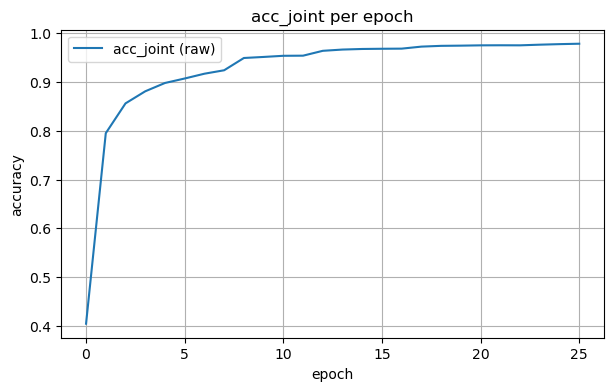

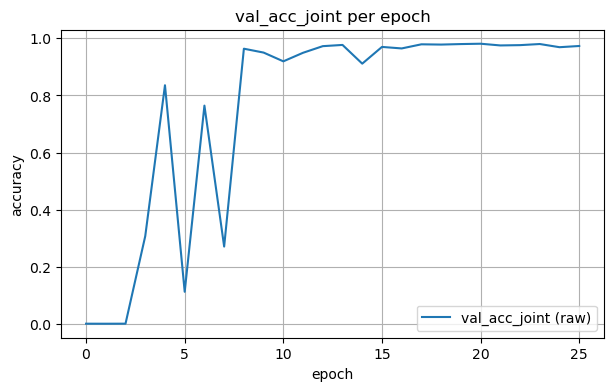

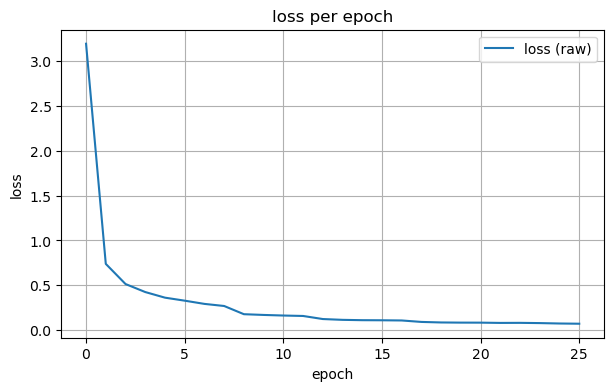

In [6]:
# === 설정 ===
LOG_DIR  = "./runs_MobileNetV2"          # train.csv가 있는 폴더
LOG_PATH = f"{LOG_DIR}/train.csv"
SMOOTH   = 1   # 이동평균(스무딩) 윈도우 크기. 1이면 원본값만 사용

import os
import pandas as pd
import numpy as np

# 1) CSV 로드
if not os.path.exists(LOG_PATH):
    raise FileNotFoundError(f"train.csv를 찾을 수 없습니다: {LOG_PATH}")

df = pd.read_csv(LOG_PATH)

# 2) 에포크 축 만들기 (CSVLogger가 epoch 컬럼을 넣어줍니다)
if "epoch" in df.columns:
    epoch = df["epoch"].to_numpy()
else:
    epoch = np.arange(len(df), dtype=int)

# 3) 필요한 컬럼 확인
need_cols = ["acc_joint", "val_acc_joint", "loss"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    print("train.csv에 아래 컬럼이 없습니다:", missing)
    print("사용 가능한 컬럼들:", list(df.columns))
    raise SystemExit

acc_joint     = df["acc_joint"].to_numpy()
val_acc_joint = df["val_acc_joint"].to_numpy()
loss          = df["loss"].to_numpy()

# 4) 스무딩(옵션)
def smooth(x, k):
    if k <= 1: 
        return x
    return pd.Series(x).rolling(k, min_periods=1, center=True).mean().to_numpy()

acc_s   = smooth(acc_joint, SMOOTH)
val_s   = smooth(val_acc_joint, SMOOTH)
loss_s  = smooth(loss, SMOOTH)

# 5) 그래프 출력
import matplotlib.pyplot as plt

# (1) acc_joint
plt.figure(figsize=(7,4))
plt.plot(epoch, acc_joint, label="acc_joint (raw)")
if SMOOTH > 1:
    plt.plot(epoch, acc_s, label=f"acc_joint (smooth {SMOOTH})")
plt.title("acc_joint per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.legend()
plt.show()

# (2) val_acc_joint
plt.figure(figsize=(7,4))
plt.plot(epoch, val_acc_joint, label="val_acc_joint (raw)")
if SMOOTH > 1:
    plt.plot(epoch, val_s, label=f"val_acc_joint (smooth {SMOOTH})")
plt.title("val_acc_joint per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.legend()
plt.show()

# (3) loss
plt.figure(figsize=(7,4))
plt.plot(epoch, loss, label="loss (raw)")
if SMOOTH > 1:
    plt.plot(epoch, loss_s, label=f"loss (smooth {SMOOTH})")
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.legend()
plt.show()

## 완성된 OCR 테스트하기
완성된 OCR을 하나씩 테스트할 수 있음.
전체 ChatGPT를 사용하여 생성함.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
파일: /home/voxfish_ljy$/virtual/제목 없음.jpg
예측 초성: ㄱ
예측 중성: ㅏ
예측 종성: ㄻ


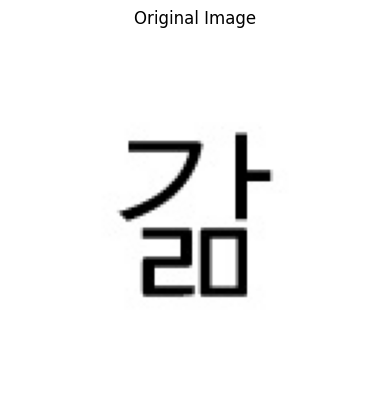

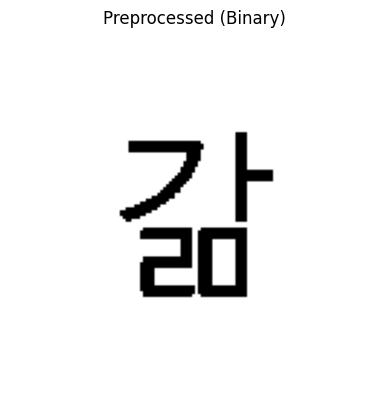

In [28]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt  # 안 쓰고 싶으면 아래 No-MPL 코드도 줄게
import os

# --- L/V/T slice index (68차원 기준) ---
L_SLICE = slice(0, 19)
V_SLICE = slice(19, 40)
T_SLICE = slice(40, 68)

# --- Loss (초/중/종성 cross entropy 합산) ---
def hangul_loss(y_true, logits):
    cho  = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, L_SLICE], logits=logits[:, L_SLICE])
    jung = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, V_SLICE], logits=logits[:, V_SLICE])
    jong = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, T_SLICE], logits=logits[:, T_SLICE])
    return cho + jung + jong

# --- Metrics ---
def acc_first(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, L_SLICE], -1), tf.argmax(y_pred[:, L_SLICE], -1)),
            tf.float32
        )
    )

def acc_middle(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, V_SLICE], -1), tf.argmax(y_pred[:, V_SLICE], -1)),
            tf.float32
        )
    )

def acc_last(y_true, y_pred):
    return tf.reduce_mean(
        tf.cast(
            tf.equal(tf.argmax(y_true[:, T_SLICE], -1), tf.argmax(y_pred[:, T_SLICE], -1)),
            tf.float32
        )
    )

def acc_joint(y_true, y_pred):
    l_ok = tf.equal(tf.argmax(y_true[:, L_SLICE], -1), tf.argmax(y_pred[:, L_SLICE], -1))
    v_ok = tf.equal(tf.argmax(y_true[:, V_SLICE], -1), tf.argmax(y_pred[:, V_SLICE], -1))
    t_ok = tf.equal(tf.argmax(y_true[:, T_SLICE], -1), tf.argmax(y_pred[:, T_SLICE], -1))
    return tf.reduce_mean(tf.cast(l_ok & v_ok & t_ok, tf.float32))

# --- 모델 로드 ---
model = tf.keras.models.load_model(
    "/home/voxfish_ljy$/virtual/runs_MobileNetV2/final.keras",
    custom_objects={
        "acc_first": acc_first,
        "acc_middle": acc_middle,
        "acc_last": acc_last,
        "acc_joint": acc_joint,
        "hangul_loss": hangul_loss
    }
)

IMG_SIZE = 128
THRESHOLD = 0.8

# 초성/중성/종성 리스트
CHOSUNG_LIST = ["ㄱ","ㄲ","ㄴ","ㄷ","ㄸ","ㄹ","ㅁ","ㅂ","ㅃ","ㅅ","ㅆ","ㅇ","ㅈ","ㅉ","ㅊ","ㅋ","ㅌ","ㅍ","ㅎ"]
JUNGSUNG_LIST = ["ㅏ","ㅐ","ㅑ","ㅒ","ㅓ","ㅔ","ㅕ","ㅖ","ㅗ","ㅘ","ㅙ","ㅚ","ㅛ","ㅜ","ㅝ","ㅞ","ㅟ","ㅠ","ㅡ","ㅢ","ㅣ"]
JONGSUNG_LIST = ["","ㄱ","ㄲ","ㄳ","ㄴ","ㄵ","ㄶ","ㄷ","ㄹ","ㄺ","ㄻ","ㄼ","ㄽ","ㄾ","ㄿ","ㅀ","ㅁ","ㅂ","ㅄ","ㅅ","ㅆ","ㅇ","ㅈ","ㅊ","ㅋ","ㅌ","ㅍ","ㅎ"]

# --- 단일 이미지 전처리 함수 ---
def preprocess_for_test(img_path: str):
    bytes_ = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(bytes_, channels=1)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)

    img = tf.cast(img, tf.float32) / 255.0
    img = tf.where(img > THRESHOLD, 1.0, 0.0)  # binary

    return img[None, ...]  # (1, H, W, 1)

# --- 예측 함수 ---
def predict_hangul(img_path):
    x = preprocess_for_test(img_path)
    pred = model.predict(x)[0]  # shape (68,)

    # 각 범위 slicing
    pL = np.argmax(pred[0:19])
    pV = np.argmax(pred[19:40])
    pT = np.argmax(pred[40:68])

    print("파일:", img_path)
    print(f"예측 초성: {CHOSUNG_LIST[pL]}")
    print(f"예측 중성: {JUNGSUNG_LIST[pV]}")
    print(f"예측 종성: {JONGSUNG_LIST[pT] if JONGSUNG_LIST[pT] != '' else '없음'}")

    # 시각 확인
    img = Image.open(img_path).convert("L")
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # 전처리된 결과도 보기
    bin_img = x.numpy().reshape(IMG_SIZE, IMG_SIZE)
    plt.imshow(bin_img, cmap="gray")
    plt.title("Preprocessed (Binary)")
    plt.axis("off")
    plt.show()

# 테스트 실행
test_img = r"/home/voxfish_ljy$/virtual/제목 없음.jpg"  # 👈 파일 경로 넣기
predict_hangul(test_img)